In [1]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Spiking Neural Network Module, inherited from tf.Module
class SNN_IaF(tf.Module):
    
    # Utility function for checking and converting parameters into tensor
    def check_parameter(self, param, n_neuron):
        # the parameter is of some array type
        if isinstance(param, (list, np.ndarray, tf.Tensor)):
            param_tensor = tf.convert_to_tensor(param, dtype=tf.float32)
            if tf.size(param_tensor) == n_neuron:
                return tf.convert_to_tensor(param, dtype=tf.float32)
            else:
                # raise error when size is incompatible
                raise ValueError('The size of the parameter {} is not the same as the number of neurons {}.'.format(tf.size(param_tensor), n_neuron))
            # the parameter is a scalar
            # converting to tensor of the same value
        return tf.fill((n_neuron,), param)
    
    # init
    def __init__(self, n_neuron, C_m, R_m, V_resting, V_reset, V_thres, name=None):
        # Set the optional name of the SSN
        super(SNN_IaF, self).__init__(name=name)
        
        # Set the parameters
        self.n_neuron = n_neuron
        self.C_m = self.check_parameter(C_m, self.n_neuron)
        self.R_m = self.check_parameter(R_m, self.n_neuron)
        self.V_resting = self.check_parameter(V_resting, self.n_neuron)
        self.V_reset = self.check_parameter(V_reset, self.n_neuron)
        self.V_thres = self.check_parameter(V_thres, self.n_neuron)
    
        # Voltage as tf.Variables
        # Initialize to V_resting
        self.V = tf.Variable(self.V_resting, name='V')
        
        # Record dictionary
        self.record = {
            'time': None,
            'I': None,
            'V': None,
            'firing': None
        }
        
    
    # finite difference update step
    @tf.function
    def finite_diff_update(self, I, dt):
        # finiate difference increment dV
        dV = (I / self.C_m - (self.V - self.V_resting) / (self.C_m * self.R_m)) * dt
        # determine the spike by checking voltage with threshold
        will_fire = self.V + dV >= self.V_thres
        # update the Voltage variable
        self.V.assign(tf.where(will_fire, self.V_reset, self.V + dV))
        # return the spike information
        return will_fire
    
    
    # simulate a period of time (sim_time) given input current I_t
    def Simulate(self, I_t, sim_time, dt=0.01, clear_history=False):
        # total step number
        total_step = int(sim_time / dt)
        # time stamps
        if self.record['time'] == None:
            self.record['time'] = [0.0]
        # current at each time stamp
        if self.record['I'] == None:
            self.record['I'] = [I_t(0.0)]
        # Voltage at each time stamp
        if self.record['V'] == None:
            self.record['V'] = [tf.identity(self.V)]
        # firing event at each time stamp
        if self.record['firing'] == None:
            self.record['firing'] = [tf.fill((self.n_neuron,), False)]
        time = self.record['time'][-1]
        for step in range(1, total_step + 1):
            # time of this step 
            time = time + dt
            # current of this steop
            I = I_t(time)
            # update voltage
            firing = self.finite_diff_update(I, dt)

            # save all the histories
            self.record['time'].append(time)
            self.record['I'].append(I)
            self.record['V'].append(tf.identity(self.V))
            self.record['firing'].append(firing)
    
    
    # Plotters
    def plot_y_vs_x(self, i, y, x, show_spikes=False):
        unit_labels = {'time': 'ms', 'I': 'mA', 'V': 'mV'}
        plt.title('Neuron simulation ({} vs. {})'.format(y, x))
        plt.ylabel('{} [{}]'.format(y, unit_labels[y]))
        plt.xlabel('{} [{}]'.format(x, unit_labels[x]))
        plt.plot(self.record[x], 
                 tf.transpose(tf.stack(self.record[y]))[i],
                 color='#0095ff')
        # show spike as vertical lines if needed
        if show_spikes:
            for t in range(len(self.record['time'])):
                if self.record['firing'][t][i]:
                    plt.axvline(
                        x=self.record['time'][t], 
                        color='#ff9b61',
                        linestyle='--')
            
            

In [3]:
# decorator for making array of constant inputs
def make_copy(n):
    def _make_copy(func):
        def copied_func(t):
            return tf.fill((n,), func(t))
        return copied_func
    return _make_copy

# number of neurons
n = 1
# periodic square wave input current
@make_copy(n)
def I_input(t):
    if t % 300 < 180 and t % 300 > 20:
        return 10.
    else:
        return 0.

single_neuron = SNN_IaF(n, 
              C_m=3.5, 
              R_m=60., 
              V_resting=-65., 
              V_reset=-70., 
              V_thres=35.)    

single_neuron.Simulate(I_input, 900, dt=0.5)

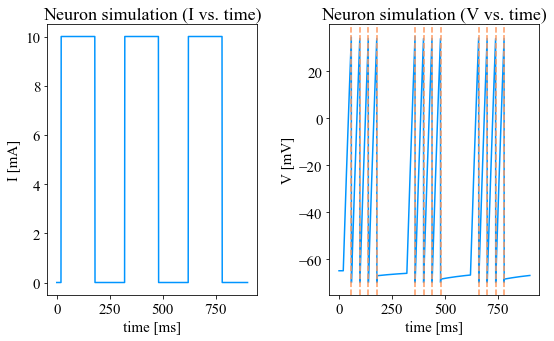

In [4]:
matplotlib.rc('font', family='Times New Roman', size=15)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
single_neuron.plot_y_vs_x(0, 'I', 'time')
plt.subplot(1, 2, 2)
single_neuron.plot_y_vs_x(0, 'V', 'time', show_spikes=True)
plt.tight_layout()
plt.savefig('single-neuron.png', dpi=100)
plt.show()